# A simple nerual network for fun!

### Definations:

$N_n$: The number of nodes in $n$-$th$ layer.

$X$: The input of ANN, equals to $O^{(1)}$. Shape: ($M$, $N_1$)

$O^{(n)}$: The output of $n$-$th$ layer, also the input of $(n+1)$-$th$ layer. Shape: $(M,N_n)$

$W^{(n)}$: The weight of $n$-$th$ layer. Shape: $(N_n, N_{n+1})$

$B^{(n)}$: The bias of $n$-$th$ layer. Shape: $(N_{n+1},)$

$A^{(n)}$: The intermediate value in each layer, equals to $O^{(n)}W^{(n)}+B^{(n)}$. Shape: $(M, N_{n+1})$

### Euqaitons:
 * Forward Propagation

\begin{align}
    O^{(n+1)} & = Active(A^{(n)}) \\
              & = Active(O^{(n)}W^{(n)}+B^{(n)}) \\
\end{align}

 * Backward Propagation

\begin{align}
    \frac{\partial E}{\partial A^{(n)}} &= \frac{\partial E}{\partial O^{(n+1)}} 
    \odot Active^\prime(A^{(n)}) \\
    \\
    \frac{\partial E}{\partial O^{(n)}} &= \frac{\partial E}{\partial A^{(n)}} {W^{(n)}}^T \\
    \\
    \frac{\partial E}{\partial W^{(n)}} &= {O^{(n)}}^T\frac{\partial E}{\partial A^{(n)}} \\
    \\
    \frac{\partial E}{\partial B^{(n)}} &= \sum_{m}\big( \frac{\partial E}{\partial A^{(n)}} \big)_{m}
\end{align}

*Matrix derivative uses denominator alignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

delta = 1e-15

In [2]:
# Util functions
def label2bin(y):
    shape = (y.shape[0], np.max(y) + 1)
    rst = np.zeros(shape, dtype = int)
    for idx, label in enumerate(y):
        rst[idx, label] = 1
    return rst

def maxCol(X):
    return np.max(X, axis = 1)[:, np.newaxis]

def sumCol(X):
    return np.sum(X, axis = 1)[:, np.newaxis]

def averCol(X):
    return np.average(X, axis = 1)[:, np.newaxis]

In [3]:
"""
Pairs of math functions.
f(x) returns the values for forward propagation. 
Df(x, dr) applies chain rule and returns derivatives of parameters for backward propagation.
"""
def mul(X, Y):
    return X.dot(Y)

def Dmul(X, Y, dLdO):
    return dLdO.dot(Y.T), X.T.dot(dLdO)

def relu(A):
    return A * (A > 0)

def Drelu(A, dLdO, O = None):
    return dLdO * (A > 0)

def sigmoid(A):
    y = 1 / (1 + np.exp(-A))
    return y

def Dsigmoid(A, dLdO, O = None):
    if O is None:
        O = sigmoid(A)
    return dLdO * O * (1 - O)

def softMax(A):
    shift = A - maxCol(A)
    exp = np.exp(shift)
    return exp / sumCol(exp)

def DsoftMax(A, dLdO, O = None):
    if O is None:
        O = softMax(A)
    O_dLdO = O * dLdO
    return O_dLdO - O * sumCol(O_dLdO)

activFunc = {
    'relu': relu,
    'sigmoid': sigmoid,
    'softMax': softMax,
}

DactivFunc = {
    'relu': Drelu,
    'sigmoid': Dsigmoid,
    'softMax': DsoftMax,
}

In [4]:
"""
Loss functions.
    inputs(
        O: Output layer
        y: True value
    )
    return(
        loss: Loss of the neural network.(without regularization)
        dLdO: Derivative of loss with respect of O
        dLdA: Derivative of loss with respect of A
    )
"""
def LSM(O, y):
    assert(O.shape == y.shape)
    M = O.shape[0]
    dLdO = O - y
    loss = np.sum(dLdO**2) / (2 * M)
    return loss, dLdO, None

# y: class label.
def labelCrossEntropy(O, y):
    M = O.shape[0]
    dLdO = -label2bin(y) / (O + delta)
    loss = -np.sum(np.log(np.choose(y, O.T) + delta)) / M
    return loss, dLdO, None

# y: class probability.
def probCrossEntropy(O, y):
    assert(O.shape == y.shape)
    M = O.shape[0]
    dLdO = -y / (O + delta)
    loss = -np.sum(np.log(O + delta) * y) / M
    return loss, dLdO, None

# For softMax output layer.
def softMaxLabelCrossEntropy(O, y):
    M = O.shape[0]
    loss = -np.sum(np.log(np.choose(y, O.T) + delta)) / M
    return loss, None, (O - label2bin(y))

def softMaxProbCrossEntropy(O, y):
    assert(O.shape == y.shape)
    loss = -np.sum(np.log(O + delta) * y) / M
    return loss, None, (O - y)

lossFunc = {
    'LSM': LSM,
    'labelCrossEntropy': labelCrossEntropy,
    'probCrossEntropy': probCrossEntropy,
    'softMaxLabelCrossEntropy': softMaxLabelCrossEntropy,
    'softMaxProbCrossEntropy': softMaxProbCrossEntropy,
}

In [23]:
"""
    A layer of nerual network
"""
class layer:
    def __init__(self, shape, activ, isOutLayer = False, loss = None, reg = 1e-1, std = 1e-1):
        assert(len(shape) == 2)
        self.W = std * np.random.randn(*shape)
        self.B = np.zeros(shape[1])
        self.reg = reg
        self.activ = activFunc[activ]
        self.Dactiv = DactivFunc[activ]
        self.isOutLayer = isOutLayer
        if isOutLayer:
            self._loss = lossFunc[loss]
        
    def forward(self, X):
        self.X = X # network input
        self.A = mul(X, self.W) + self.B
        self.O = self.activ(self.A) # network output
        return self.O
    
    def backward(self, rate, dLdO = None):
        dLdA = None
        if self.isOutLayer:
            dLdA = self.dLdA
            dLdO = self.dLdO
        
        if dLdA is None:
            dLdA = self.Dactiv(self.A, dLdO, self.O)
        
        dLdB = np.average(dLdA, axis = 0)
        self.B -= rate * dLdB
        
        M = self.O.shape[0]
        dLdO, dLdW = Dmul(self.X, self.W, dLdA)
        self.W -= rate * (dLdW / M + self.reg * self.W)
        
        return dLdO
    
    def regLoss(self):
        return self.reg * np.sum(self.W**2) / 2
    
    def loss(self, y):
        rst, self.dLdO, self.dLdA =  self._loss(self.O, y)
        return rst
    
"""
    neural network
"""
class simpleNN:
    """
        init a neural network.
        inputs(
            layers:  A list of dict, i.e. 
                        [{   
                             shape : (10, 20)
                             activ : 'sigmoid',
                         },
                         {   
                             shape : (20, 40)
                             activ : 'sigmoid',
                         },
                         {   
                             shape : (40, 10)
                             activ : 'sigmoid',
                             loss  : 'LSM',
                             isOutLayer : True
                             
                         }]
                    It specifies the node number and activation function of each layer. 
                    For output layer, the loss function should also be given.
        )
    """
    def __init__(self, layers, reg = 1e-1, std = 1e-1):
        ly = []
        for l in layers:
            ly.append(layer(l['shape'], 
                            l['activ'], 
                            l.get('isOutLayer', False), 
                            l.get('loss', None),
                            reg, std
                           ))
        self.layers = ly
    
    def forward(self, X, y = None):
        regLoss = 0
        for l in self.layers:
            X = l.forward(X)
            regLoss += l.regLoss()
        
        loss = 0
        if y is not None:
            loss = self.layers[-1].loss(y)

        return X, loss, regLoss

    def backward(self, step):
        dLdO = None
        for l in reversed(self.layers):
            dLdO = l.backward(step, dLdO)
    
    def train(self, X_train, y_train, X_val, y_val, 
              rate = 1e-3, epochs = 20, batchSz = 200, rateDecay = 1, 
              verbose = True):

        num = X_train.shape[0]
        ite = int(max(1, num / batchSz))
        
        iteInfoHistory = []
        batchInfoHistory = []
        for epoch in range(epochs):
            perm = np.random.permutation(num)
            for i in range(ite):
                ids = perm[i * batchSz: (i + 1) * batchSz]
                X_batch = X_train[ids, :]
                y_batch = y_train[ids]
                
                _, loss, regLoss = self.forward(X_batch, y_batch)
                self.backward(rate)
                iteInfoHistory.append({
                    'loss': loss,
                    'regLoss': regLoss
                })
            
            rate *= rateDecay
            
            # Training Infomation
            train_pred, train_loss, _ = self.forward(X_train, y_train)
            val_pred, val_loss, _ = self.forward(X_val, y_val)
            train_accuracy = np.mean(np.argmax(train_pred, axis = 1) == y_train)
            val_accuracy = np.mean(np.argmax(val_pred, axis = 1) == y_val)
            
            batchInfoHistory.append({
                'train_accuracy': train_accuracy,
                'train_loss': train_loss,
                'val_accuracy': val_accuracy,
                'val_loss': val_loss
            })
            
            if verbose:
                print('------------------epoch:', epoch, '------------------' )
                print('train_accuracy: %.5f' % train_accuracy, ' loss: %.5f'% train_loss)
                print('val_accuracy : %.5f' % val_accuracy, ' loss: %.5f\n'% val_loss)
        
        self.iteInfoHistory = iteInfoHistory
        self.batchInfoHistory = batchInfoHistory
    
    def showTrainInfo(self):
        lossHistory = [d['loss'] for d in self.iteInfoHistory]
        regLossHistory = [d['regLoss'] for d in self.iteInfoHistory]
        
        plt.figure()
        plt.plot(lossHistory, color = 'b')
        plt.plot(regLossHistory, color = 'y')
        
        trainAccuracyHistory = [d['train_accuracy'] for d in self.batchInfoHistory]
        trainLossHistory = [d['train_loss'] for d in self.batchInfoHistory]
        valAccuracyHistory = [d['val_accuracy'] for d in self.batchInfoHistory]
        valLossHistory = [d['val_loss'] for d in self.batchInfoHistory]
        
        plt.figure()
        plt.plot(trainAccuracyHistory, color = 'r')
        plt.plot(valAccuracyHistory, color = 'c')
        
        plt.figure()
        plt.plot(trainLossHistory, color = 'b')
        plt.plot(valLossHistory, color = 'y')
        plt.show()

In [24]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST-original', data_home='datasets/mnist')
X = mnist['data'].astype(float)
y = mnist['target'].astype(int)
I = np.random.permutation(X.shape[0])
X = X[I, :]
y = y[I]

X_train = X[:50000, :]
y_train = y[:50000]
X_test = X[50000:, :]
y_test = y[50000:]

In [25]:
layers = [
    {
        'shape': (784, 32),
        'activ': 'relu',
    },
    {
        'shape': (32, 32),
        'activ': 'relu',
    },
    {
        'shape': (32, 32),
        'activ': 'relu',
    },
    {
        'shape': (32, 10),
        'activ': 'softMax',
        'isOutLayer' : True,
        'loss' : 'labelCrossEntropy'
    }
]
snn = simpleNN(layers)

In [26]:
snn.train(X_train, y_train, X_test, y_test, epochs = 10)

------------------epoch: 0 ------------------
train_accuracy: 0.60892  loss: 1.19254
val_accuracy : 0.60175  loss: 1.22204

------------------epoch: 1 ------------------
train_accuracy: 0.70414  loss: 0.90278
val_accuracy : 0.69855  loss: 0.92075

------------------epoch: 2 ------------------
train_accuracy: 0.75850  loss: 0.74974
val_accuracy : 0.75170  loss: 0.77095

------------------epoch: 3 ------------------
train_accuracy: 0.78244  loss: 0.67760
val_accuracy : 0.77635  loss: 0.69819

------------------epoch: 4 ------------------
train_accuracy: 0.81034  loss: 0.60419
val_accuracy : 0.80535  loss: 0.62229

------------------epoch: 5 ------------------
train_accuracy: 0.82674  loss: 0.55484
val_accuracy : 0.82205  loss: 0.57292

------------------epoch: 6 ------------------
train_accuracy: 0.83966  loss: 0.51845
val_accuracy : 0.83370  loss: 0.53486

------------------epoch: 7 ------------------
train_accuracy: 0.84616  loss: 0.49462
val_accuracy : 0.84015  loss: 0.51083

--------

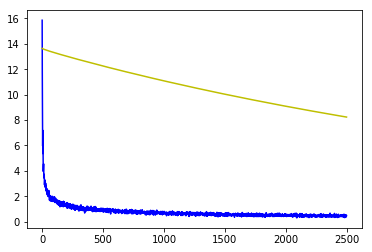

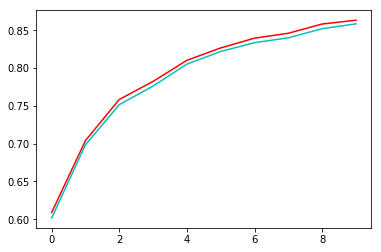

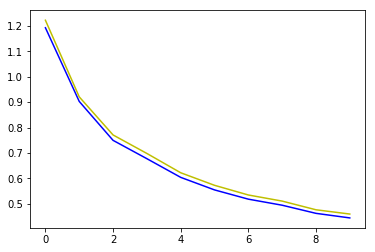

In [27]:
snn.showTrainInfo()